In [ ]:
# ══════════════════════════════════════════════════════════════════════════════
# Merge Pipeline & Performance Analysis
# ══════════════════════════════════════════════════════════════════════════════

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), "..")))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from config import settings
from utils.risk_merge import RiskIndicatorMerger

In [13]:
# ── ModelEvaluator ─────────────────────────────────────────────────────────

class ModelEvaluator:
    """
    Trains a RandomForestRegressor on a single region's time series and
    evaluates on a held-out window.

    Supports running the same region with different predictor sets so
    baseline vs enhanced can be compared fairly.
    """

    def __init__(
        self,
        n_estimators: int = 100,
        holdout_months: int = 6,
        random_state: int = 42,
    ):
        self.n_estimators = n_estimators
        self.holdout_months = holdout_months
        self.random_state = random_state

    def evaluate(
        self,
        df: pd.DataFrame,
        region: str,
        target: str,
        predictors: list,
        label: str = "",
    ) -> dict | None:
        """
        Train + evaluate for one (region, target, predictor set).
        Returns dict with metrics or None if region has insufficient data.
        """
        region_df = (
            df[df["matched_admin1_id"] == region]
            .sort_values("month_year")
            .copy()
        )

        if len(region_df) < self.holdout_months + 6:
            return None

        train = region_df.iloc[: -self.holdout_months]
        test = region_df.iloc[-self.holdout_months :]

        available = [p for p in predictors if p in train.columns]
        X_train = train[available].fillna(0)
        X_test = test[available].fillna(0)
        y_train = train[target].fillna(0)
        y_test = test[target].fillna(0)

        rf = RandomForestRegressor(
            n_estimators=self.n_estimators,
            random_state=self.random_state,
        )
        rf.fit(X_train, y_train, sample_weight=train["importance_weight"].fillna(1))
        y_pred = rf.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)

        nonzero = y_test != 0
        if nonzero.any():
            mape = np.mean(np.abs((y_test[nonzero] - y_pred[nonzero]) / y_test[nonzero])) * 100
        else:
            mape = np.nan

        return {
            "region": region,
            "label": label,
            "mae": round(mae, 2),
            "mape": round(mape, 2) if not np.isnan(mape) else np.nan,
            "n_predictors": len(available),
            "train_rows": len(train),
            "test_rows": len(test),
            "y_test": y_test.values,
            "y_pred": y_pred,
            "feature_importances": pd.Series(
                rf.feature_importances_, index=available
            ).sort_values(ascending=False),
        }

print("ModelEvaluator defined.")

ModelEvaluator defined.


In [14]:
# ── Helper functions ───────────────────────────────────────────────────────

def find_top_regions(df: pd.DataFrame, targets: list, n: int = 10) -> list:
    """
    Find the n admin-1 regions with the highest total target event counts.
    Sums across all target columns to rank by overall conflict activity.
    """
    available_targets = [t for t in targets if t in df.columns]
    activity = (
        df.groupby("matched_admin1_id")[available_targets]
        .sum()
        .sum(axis=1)
        .sort_values(ascending=False)
    )
    return activity.head(n).index.tolist()


def run_comparison(
    df: pd.DataFrame,
    regions: list,
    target: str,
    baseline_preds: list,
    enhanced_preds: list,
    evaluator: ModelEvaluator,
) -> pd.DataFrame:
    """
    Run baseline vs enhanced evaluation across all regions for one target.
    Returns a tidy DataFrame with all results.
    """
    records = []
    for region in regions:
        for label, preds in [
            ("Baseline", baseline_preds),
            ("Enhanced", enhanced_preds),
        ]:
            result = evaluator.evaluate(df, region, target, preds, label)
            if result is not None:
                records.append(result)

    return pd.DataFrame(records)


def build_comparison_table(results_df: pd.DataFrame) -> pd.DataFrame:
    """Pivot results into a side-by-side MAE/MAPE comparison table."""
    mae_pivot = results_df.pivot(index="region", columns="label", values="mae")
    mape_pivot = results_df.pivot(index="region", columns="label", values="mape")

    table = pd.DataFrame({
        "MAE Baseline": mae_pivot["Baseline"],
        "MAE Enhanced": mae_pivot["Enhanced"],
        "MAE Diff": mae_pivot["Baseline"] - mae_pivot["Enhanced"],
        "MAE % Change": ((mae_pivot["Enhanced"] - mae_pivot["Baseline"]) / mae_pivot["Baseline"] * 100).round(1),
        "MAPE Baseline": mape_pivot["Baseline"],
        "MAPE Enhanced": mape_pivot["Enhanced"],
    })
    return table.sort_values("MAE Diff", ascending=False)


def plot_comparison(results_df: pd.DataFrame, target: str):
    """Bar chart comparing MAE across regions for baseline vs enhanced."""
    mae_pivot = results_df.pivot(index="region", columns="label", values="mae")
    mae_pivot = mae_pivot.sort_values("Baseline", ascending=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(mae_pivot))
    width = 0.35

    bars1 = ax.barh(x - width / 2, mae_pivot["Baseline"], width, label="Baseline", color="#4C72B0")
    bars2 = ax.barh(x + width / 2, mae_pivot["Enhanced"], width, label="Enhanced (+ risk indicators)", color="#DD8452")

    ax.set_yticks(x)
    ax.set_yticklabels(mae_pivot.index, fontsize=9)
    ax.set_xlabel("MAE (lower is better)")
    ax.set_title(f"Baseline vs Enhanced — MAE for '{target}' (top 10 regions)")
    ax.legend()
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_forecasts(results_df: pd.DataFrame, target: str):
    """Plot actual vs predicted for each region, baseline and enhanced side by side."""
    regions = results_df["region"].unique()
    n = len(regions)
    fig, axes = plt.subplots(n, 2, figsize=(14, 3 * n), sharex=True)

    if n == 1:
        axes = axes.reshape(1, 2)

    for i, region in enumerate(regions):
        for j, label in enumerate(["Baseline", "Enhanced"]):
            row = results_df[(results_df["region"] == region) & (results_df["label"] == label)]
            if row.empty:
                continue
            row = row.iloc[0]
            ax = axes[i, j]
            months = np.arange(len(row["y_test"]))
            ax.plot(months, row["y_test"], "o-", label="Actual", markersize=5)
            ax.plot(months, row["y_pred"], "x--", label="Predicted", markersize=5)
            ax.set_title(f"{region} — {label} (MAE={row['mae']})", fontsize=9)
            ax.legend(fontsize=7)
            ax.grid(alpha=0.3)

    fig.suptitle(f"Forecast Comparison: '{target}'", fontsize=13, y=1.01)
    plt.tight_layout()
    plt.show()

print("Helper functions defined.")

Helper functions defined.


---
# Step 1: Build the Merged Dataset

In [ ]:
# ── Run the merger ─────────────────────────────────────────────────────────
MODEL_DATA_PATH = "../data/processed/model_data.csv"
MASTER_RAW_PATH = "../data/raw/master_raw.csv"

merger = RiskIndicatorMerger(lag=1)
merged_df = merger.merge(MODEL_DATA_PATH, MASTER_RAW_PATH)

# Inspect results
print(f"Merged shape: {merged_df.shape}")
print(f"\nOriginal predictors ({len(settings.predictors)}):")
print(f"  {settings.predictors}")
print(f"\nNew risk columns (current month): {merger.risk_cols_}")
print(f"New risk columns (lagged t-1):    {merger.risk_cols_lagged_}")
print(f"\nEnhanced predictors ({len(merger.get_enhanced_predictors())} total):")
print(f"  = {len(settings.predictors)} baseline + {len(merger.risk_cols_lagged_)} risk indicators")

# Coverage check
signal_mask = merged_df[merger.risk_cols_].sum(axis=1) > 0
lagged_mask = merged_df[merger.risk_cols_lagged_].sum(axis=1) > 0
print(f"\nRows with any risk signal (current): {signal_mask.sum():,} / {len(merged_df):,} ({signal_mask.mean()*100:.1f}%)")
print(f"Rows with any risk signal (lagged):  {lagged_mask.sum():,} / {len(merged_df):,} ({lagged_mask.mean()*100:.1f}%)")

In [16]:
# ── Preview the merged data ────────────────────────────────────────────────
preview_cols = (
    ["matched_admin1_id", "month_year"]
    + merger.risk_cols_lagged_
    + settings.targets
)
# Show rows that actually have risk signal
sample = merged_df[lagged_mask][preview_cols].head(20)
display(sample)

,matched_admin1_id,month_year,risk_contested_election (t-1),risk_crop_failure (t-1),risk_economic_concern (t-1),risk_ethnic_tension (t-1),risk_military_coup (t-1),risk_natural_disaster (t-1),risk_political_assassination (t-1),Battles,Explosions/Remote violence,Violence against civilians
116,ABW - Aruba,2020-03-01,2,0,0,0,0,0,0,0,0,0
123,ABW - Aruba,2020-10-01,0,0,1,0,0,2,0,0,0,0
124,ABW - Aruba,2020-11-01,0,0,1,0,0,2,0,0,0,0
127,ABW - Aruba,2021-02-01,0,0,1,0,0,2,0,0,0,0
139,ABW - Aruba,2022-02-01,0,0,0,0,0,0,1,0,0,0
169,ABW - Aruba,2024-08-01,0,0,0,0,0,0,1,0,0,0
171,ABW - Aruba,2024-10-01,1,0,0,0,0,0,0,0,0,0
172,ABW - Aruba,2024-11-01,0,0,0,0,0,1,0,0,0,0
175,ABW - Aruba,2025-02-01,0,0,1,0,0,0,0,0,0,1
176,ABW - Aruba,2025-03-01,1,0,0,0,0,13,0,0,0,0


---
# Step 2: Identify the 10 Most Active Regions

In [17]:
# ── Find top 10 regions by total conflict activity ─────────────────────────
top_10 = find_top_regions(merged_df, settings.targets, n=10)

# Show their activity breakdown
activity_detail = (
    merged_df[merged_df["matched_admin1_id"].isin(top_10)]
    .groupby("matched_admin1_id")[settings.targets]
    .sum()
)
activity_detail["Total"] = activity_detail.sum(axis=1)
activity_detail = activity_detail.sort_values("Total", ascending=False)

print("Top 10 most active regions (sum of all target events 2018–2025):\n")
display(activity_detail)

Top 10 most active regions (sum of all target events 2018–2025):



,Battles,Explosions/Remote violence,Violence against civilians,Total
matched_admin1_id,,,,
UKR - Donetsk,48118,55161,139,103418
UKR - Kharkiv,6234,17367,205,23806
UKR - Sumy,362,21908,31,22301
SYR - Idlib,2624,18614,925,22163
PSX - Gaza,1700,18714,589,21003
UKR - Kherson,2462,17503,336,20301
BRA - Rio de Janeiro,17594,69,2359,20022
SYR - Aleppo,4427,12501,2445,19373
UKR - Zaporizhzhia,3070,14787,196,18053


---
# Step 3: Performance Comparison — Baseline vs Enhanced

For each of the top 10 regions, we train two Random Forest models on **Battles**:
- **Baseline**: original 32 predictors from `settings.predictors`
- **Enhanced**: 32 original + 7 lagged risk indicators (t-1) = 39 predictors

Both use the same train/test split (last 6 months held out), same hyperparameters, same importance weighting.

In [18]:
# ── Run head-to-head: Battles ──────────────────────────────────────────────
evaluator = ModelEvaluator(n_estimators=100, holdout_months=6)

baseline_preds = settings.predictors
enhanced_preds = merger.get_enhanced_predictors()

TARGET = "Battles"

results_battles = run_comparison(
    merged_df, top_10, TARGET, baseline_preds, enhanced_preds, evaluator
)

print(f"Evaluated {len(results_battles) // 2} regions for '{TARGET}'\n")

# Build comparison table
table_battles = build_comparison_table(results_battles)
display(table_battles)

# Averages
avg_b = table_battles["MAE Baseline"].mean()
avg_e = table_battles["MAE Enhanced"].mean()
improved = (table_battles["MAE Diff"] > 0).sum()
total = len(table_battles)

print(f"\nAverage MAE — Baseline: {avg_b:.2f}  |  Enhanced: {avg_e:.2f}")
print(f"Regions improved: {improved}/{total}")
print(f"Overall MAE change: {((avg_e - avg_b) / avg_b * 100):+.1f}%")

Evaluated 10 regions for 'Battles'



,MAE Baseline,MAE Enhanced,MAE Diff,MAE % Change,MAPE Baseline,MAPE Enhanced
region,,,,,,
UKR - Kherson,11.20,8.57,2.63,-23.5,17.54,13.13
UKR - Luhansk,34.29,33.99,0.30,-0.9,65.32,64.62
BRA - Rio de Janeiro,19.98,20.57,-0.59,3.0,11.47,11.80
UKR - Zaporizhzhia,38.99,39.67,-0.68,1.7,35.26,35.80
PSX - Gaza,38.37,39.49,-1.12,2.9,931.59,1018.95
UKR - Sumy,39.88,41.08,-1.20,3.0,77.69,84.58
SYR - Aleppo,50.71,52.48,-1.77,3.5,427.72,445.56
SYR - Idlib,26.54,28.43,-1.89,7.1,2002.75,2144.71
UKR - Kharkiv,34.60,37.18,-2.58,7.5,11.64,12.70



Average MAE — Baseline: 55.01  |  Enhanced: 56.27
Regions improved: 2/10
Overall MAE change: +2.3%


In [19]:
# ── Run head-to-head: Violence against civilians ──────────────────────────
TARGET_2 = "Violence against civilians"

results_vac = run_comparison(
    merged_df, top_10, TARGET_2, baseline_preds, enhanced_preds, evaluator
)

print(f"Evaluated {len(results_vac) // 2} regions for '{TARGET_2}'\n")

table_vac = build_comparison_table(results_vac)
display(table_vac)

avg_b2 = table_vac["MAE Baseline"].mean()
avg_e2 = table_vac["MAE Enhanced"].mean()
improved2 = (table_vac["MAE Diff"] > 0).sum()

print(f"\nAverage MAE — Baseline: {avg_b2:.2f}  |  Enhanced: {avg_e2:.2f}")
print(f"Regions improved: {improved2}/{len(table_vac)}")
print(f"Overall MAE change: {((avg_e2 - avg_b2) / avg_b2 * 100):+.1f}%")

Evaluated 10 regions for 'Violence against civilians'



,MAE Baseline,MAE Enhanced,MAE Diff,MAE % Change,MAPE Baseline,MAPE Enhanced
region,,,,,,
UKR - Sumy,1.57,1.02,0.55,-35.0,NaN,NaN
BRA - Rio de Janeiro,3.81,3.39,0.42,-11.0,16.47,14.39
UKR - Donetsk,2.82,2.59,0.23,-8.2,140.25,127.08
SYR - Aleppo,19.47,19.32,0.15,-0.8,108.77,107.90
UKR - Kherson,1.37,1.31,0.06,-4.4,NaN,NaN
UKR - Luhansk,0.37,0.37,0.00,0.0,64.00,54.00
UKR - Zaporizhzhia,0.70,0.78,-0.08,11.4,23.00,14.50
UKR - Kharkiv,1.27,1.40,-0.13,10.2,96.75,89.00
PSX - Gaza,15.90,16.04,-0.14,0.9,60.80,61.78



Average MAE — Baseline: 5.33  |  Enhanced: 5.30
Regions improved: 5/10
Overall MAE change: -0.5%


---
# Step 4: Visualizations

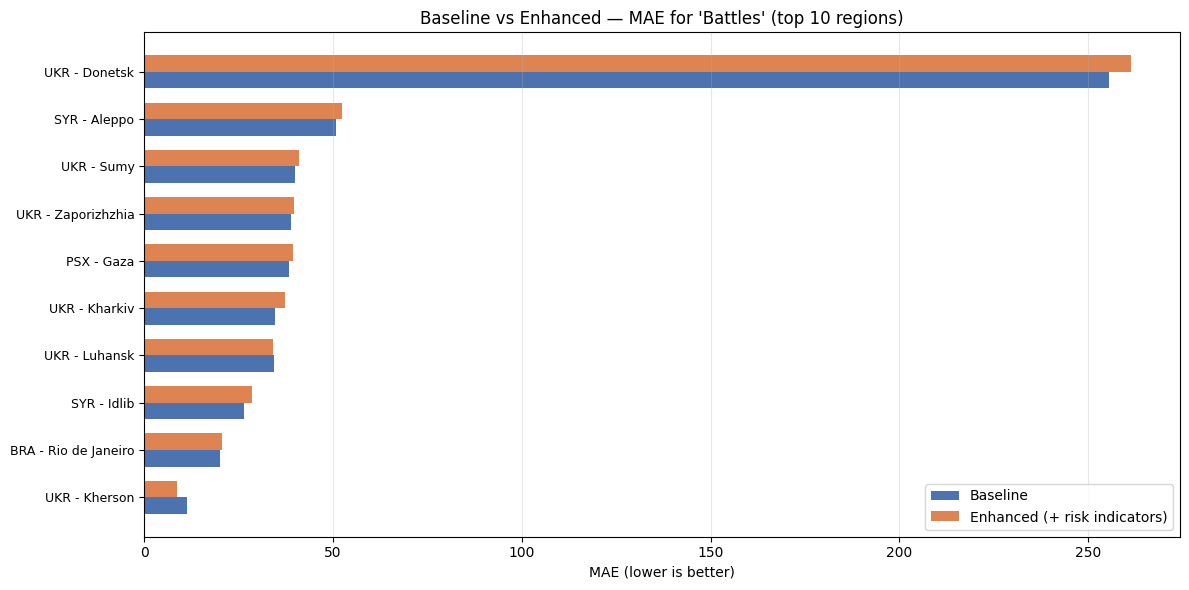

In [20]:
# ── MAE bar charts ─────────────────────────────────────────────────────────
plot_comparison(results_battles, "Battles")

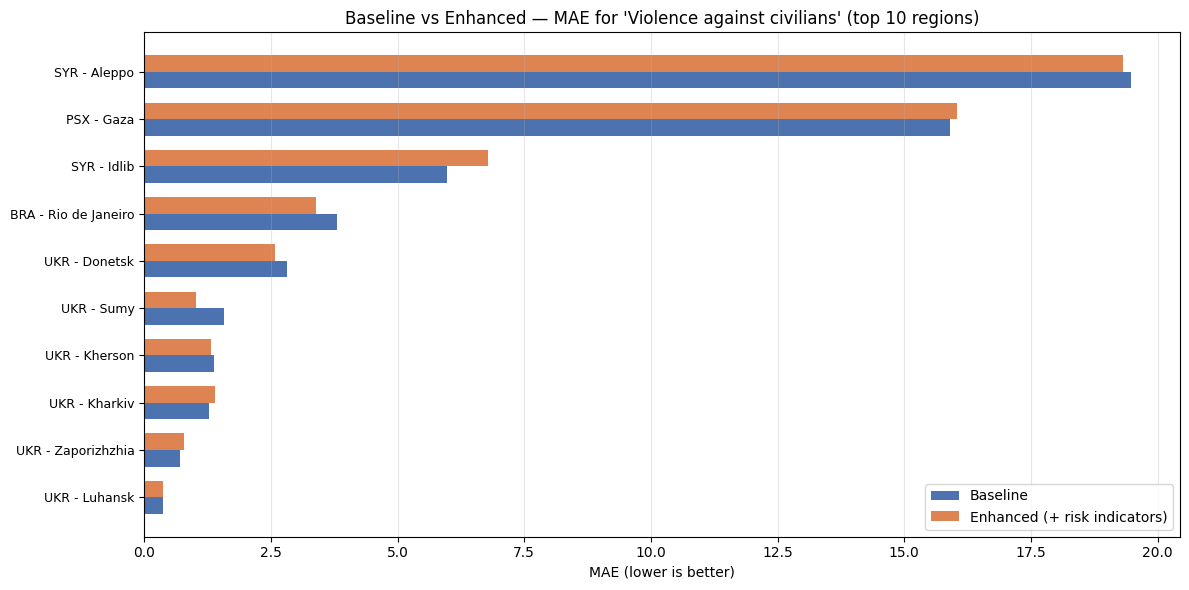

In [21]:
plot_comparison(results_vac, "Violence against civilians")

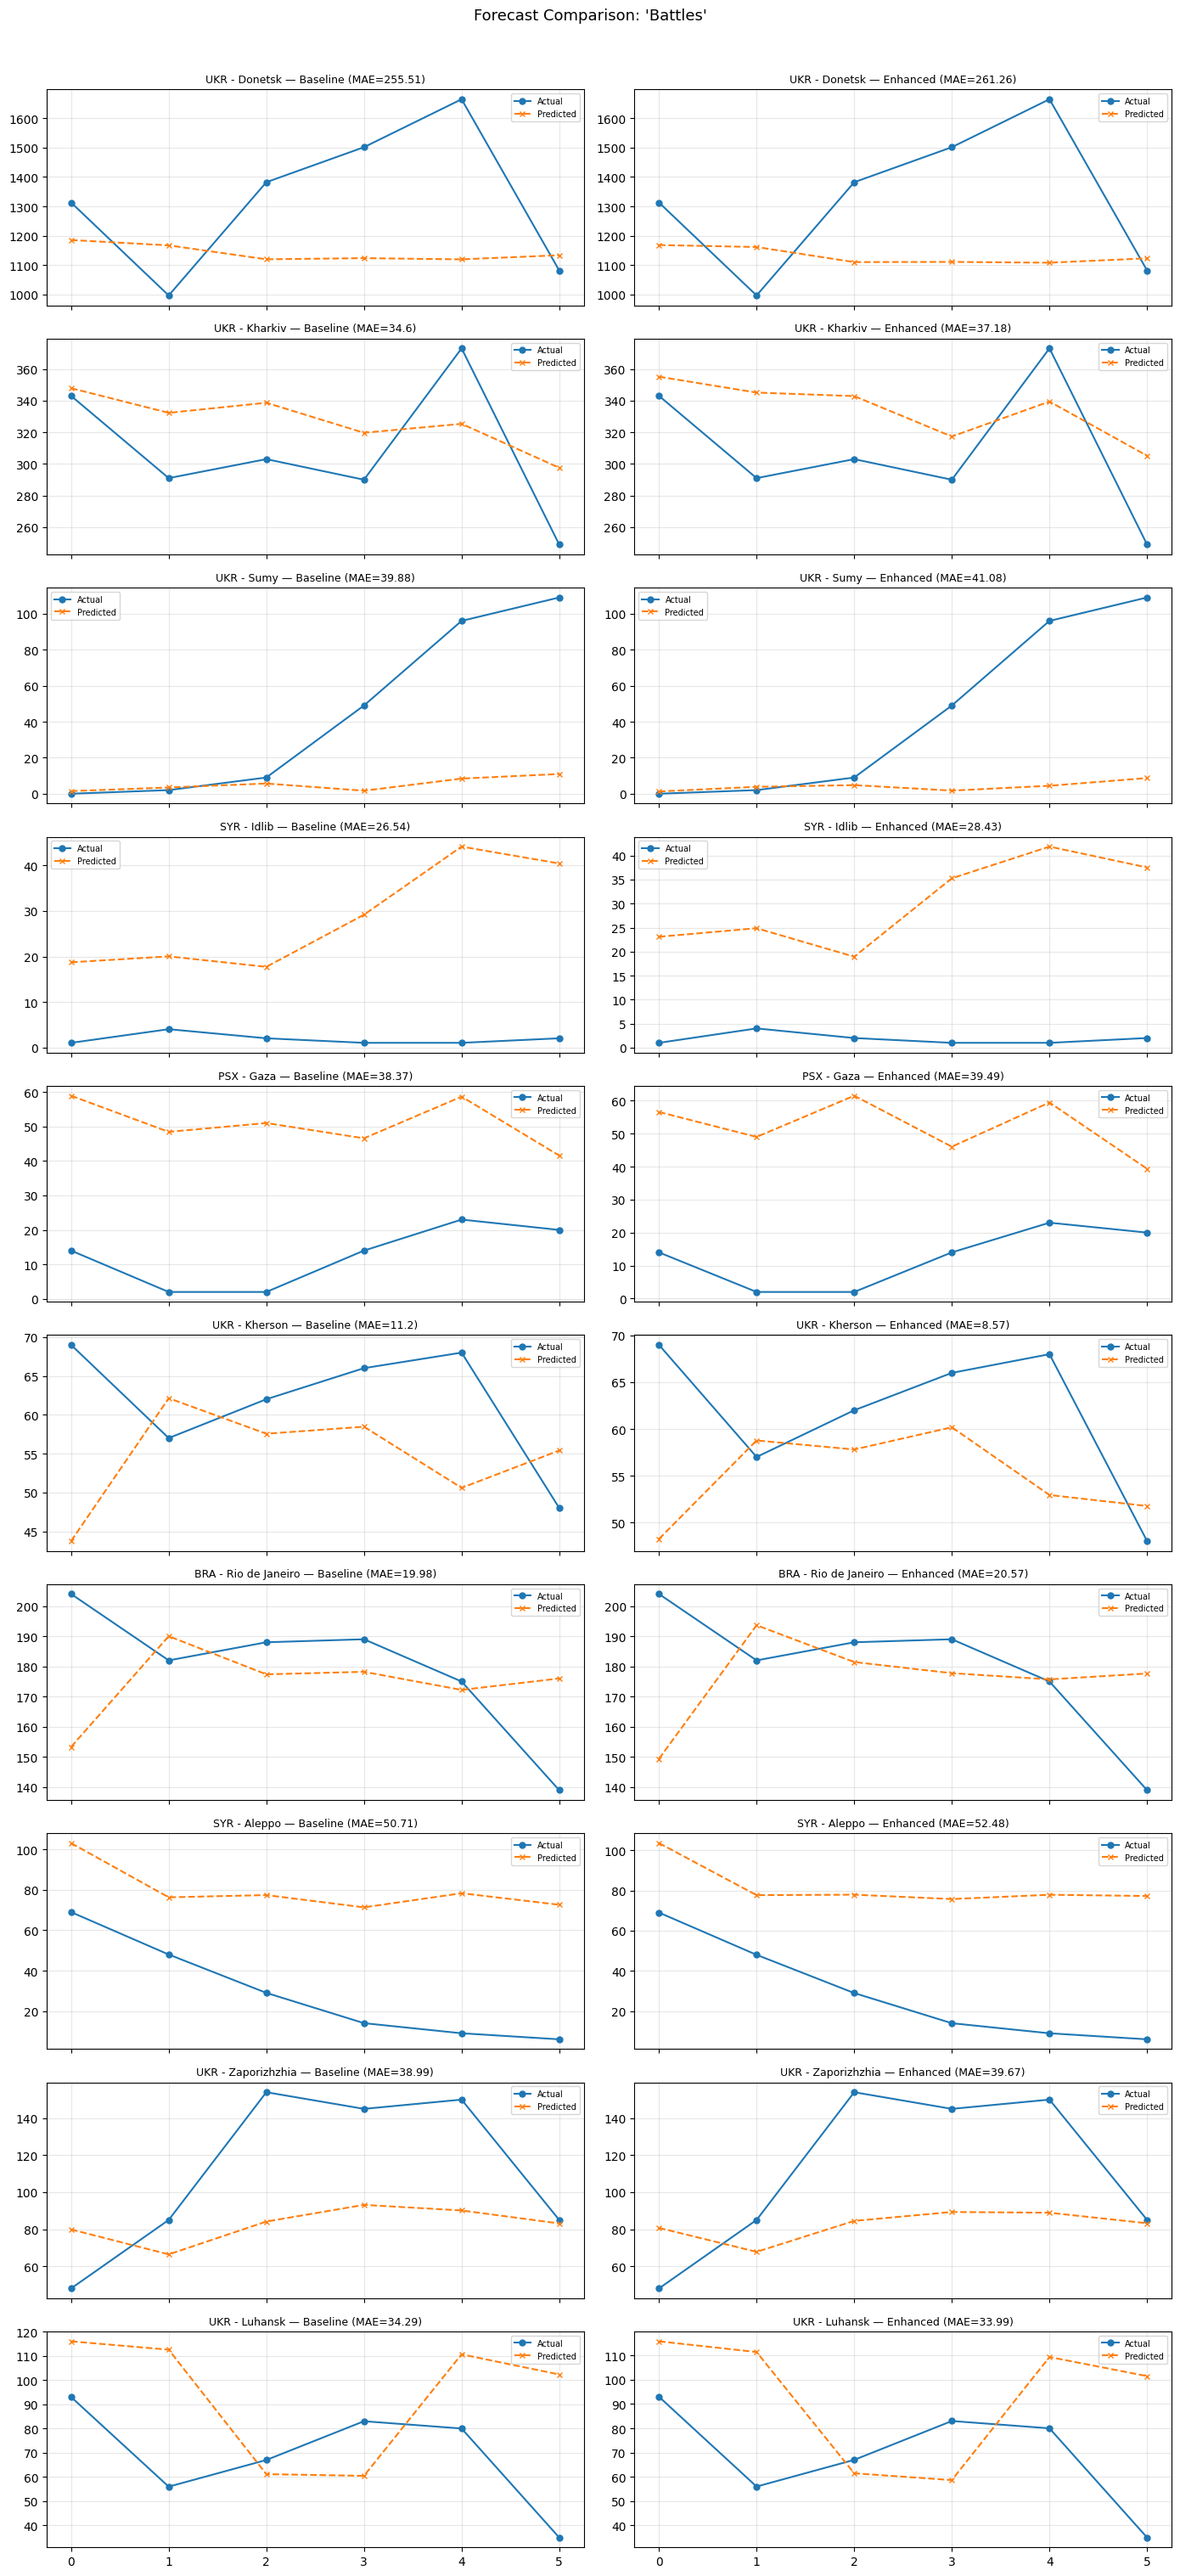

In [22]:
# ── Forecast plots: Actual vs Predicted (Battles) ──────────────────────────
plot_forecasts(results_battles, "Battles")

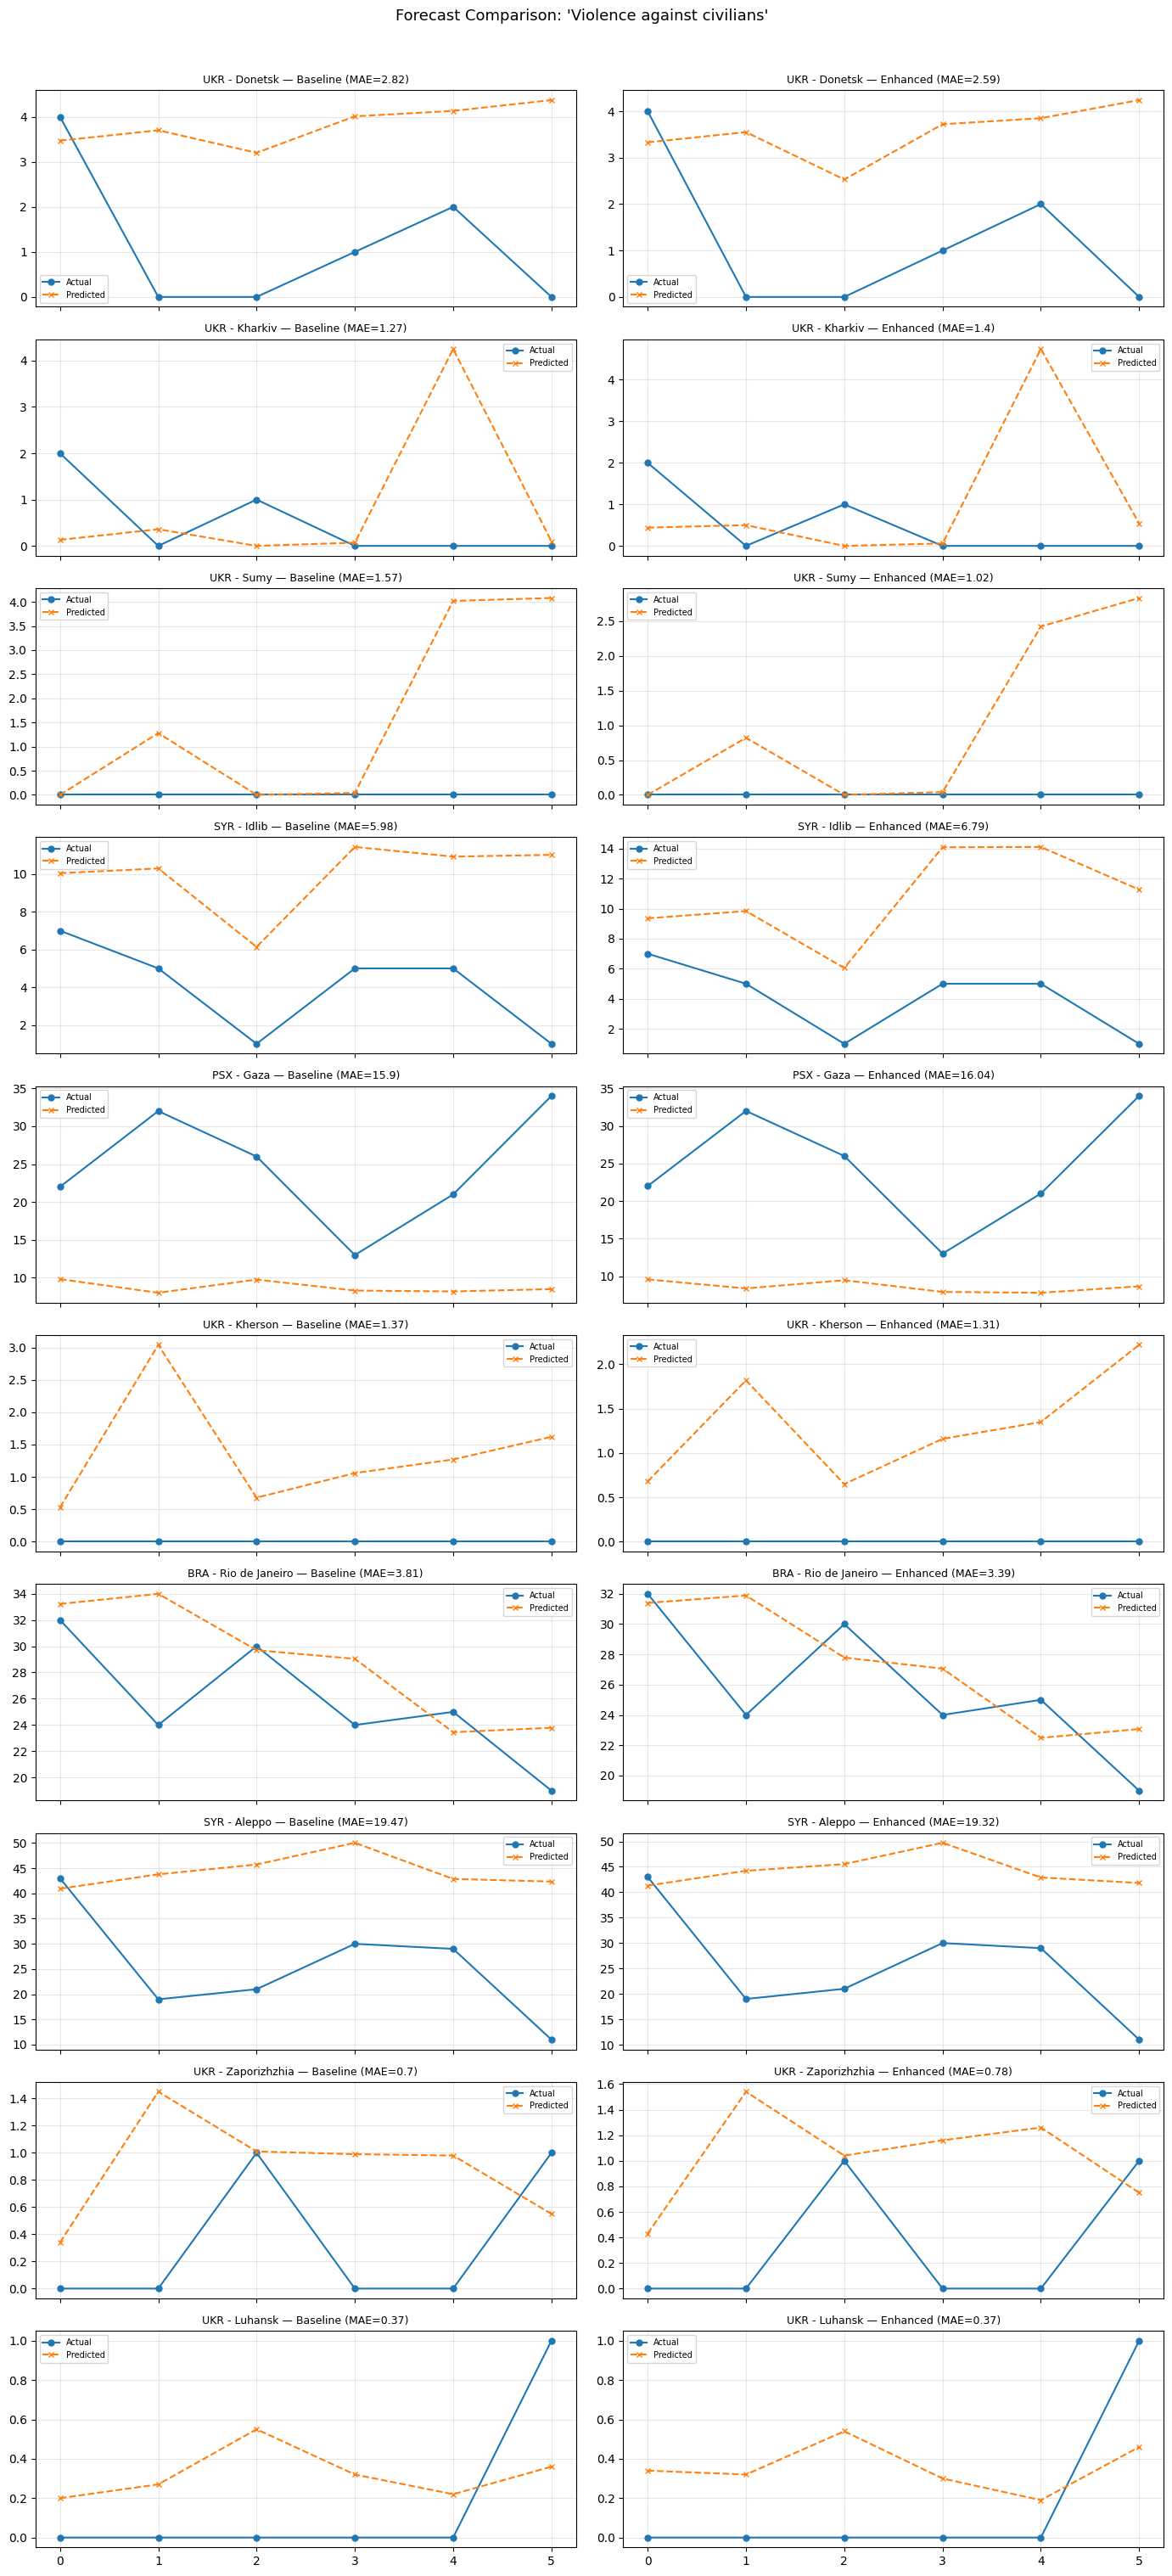

In [23]:
# ── Forecast plots: Actual vs Predicted (Violence against civilians) ───────
plot_forecasts(results_vac, "Violence against civilians")

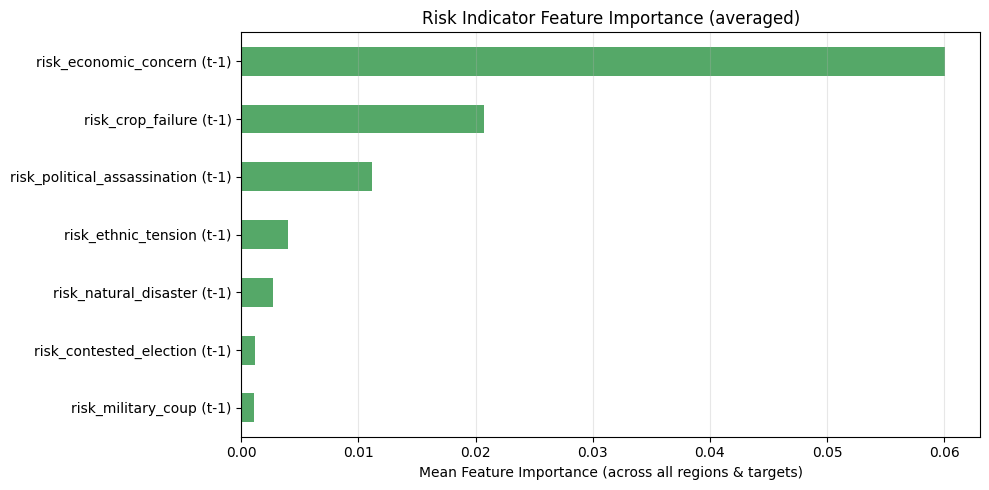

In [24]:
# ── Feature importance: which risk indicators matter most? ─────────────────
# Aggregate feature importances from all enhanced models across both targets
all_enhanced = pd.concat([results_battles, results_vac])
enhanced_only = all_enhanced[all_enhanced["label"] == "Enhanced"]

# Collect importances and average them
fi_frames = []
for _, row in enhanced_only.iterrows():
    fi = row["feature_importances"]
    # Filter to only the risk columns
    risk_fi = fi[[c for c in fi.index if c.startswith("risk_")]]
    if not risk_fi.empty:
        fi_frames.append(risk_fi)

if fi_frames:
    avg_fi = pd.concat(fi_frames, axis=1).mean(axis=1).sort_values(ascending=True)

    fig, ax = plt.subplots(figsize=(10, 5))
    avg_fi.plot(kind="barh", ax=ax, color="#55A868")
    ax.set_xlabel("Mean Feature Importance (across all regions & targets)")
    ax.set_title("Risk Indicator Feature Importance (averaged)")
    ax.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance data available for risk columns.")

---
# Step 5: Summary

In [25]:
# ── Final summary across both targets ──────────────────────────────────────
print("=" * 70)
print("OVERALL SUMMARY")
print("=" * 70)

summary_rows = []
for target_name, table in [("Battles", table_battles), ("Violence against civilians", table_vac)]:
    n_improved = (table["MAE Diff"] > 0).sum()
    n_total = len(table)
    avg_baseline = table["MAE Baseline"].mean()
    avg_enhanced = table["MAE Enhanced"].mean()
    pct_change = (avg_enhanced - avg_baseline) / avg_baseline * 100

    summary_rows.append({
        "Target": target_name,
        "Regions tested": n_total,
        "Regions improved": n_improved,
        "Avg MAE (Baseline)": round(avg_baseline, 2),
        "Avg MAE (Enhanced)": round(avg_enhanced, 2),
        "Avg MAE Change %": f"{pct_change:+.1f}%",
    })

summary = pd.DataFrame(summary_rows).set_index("Target")
display(summary)

print(f"""
Predictor sets:
  Baseline:  {len(baseline_preds)} features (lagged events + neighbours + temporal + weights)
  Enhanced:  {len(enhanced_preds)} features (baseline + {len(merger.risk_cols_lagged_)} lagged risk indicators)

Risk indicators added:
  {chr(10).join(f'  - {c}' for c in merger.risk_cols_lagged_)}
""")

OVERALL SUMMARY


,Regions tested,Regions improved,Avg MAE (Baseline),Avg MAE (Enhanced),Avg MAE Change %
Target,,,,,
Battles,10,2,55.01,56.27,+2.3%
Violence against civilians,10,5,5.33,5.30,-0.5%



Predictor sets:
  Baseline:  31 features (lagged events + neighbours + temporal + weights)
  Enhanced:  38 features (baseline + 7 lagged risk indicators)

Risk indicators added:
    - risk_contested_election (t-1)
  - risk_crop_failure (t-1)
  - risk_economic_concern (t-1)
  - risk_ethnic_tension (t-1)
  - risk_military_coup (t-1)
  - risk_natural_disaster (t-1)
  - risk_political_assassination (t-1)

